In [1]:
import pandas as pd

file_path = "dataset.xlsx"

ib_data = pd.read_excel(file_path, sheet_name="DATA IB")
ik_data = pd.read_excel(file_path, sheet_name="DATA IK")

# kolom yang relevan --> 'keperluan'
ib_data = ib_data[["desc"]].rename(columns={"desc": "keperluan"})
ik_data = ik_data[["tujuan"]].rename(columns={"tujuan": "keperluan"})

ib_data["izin"] = "IB"
ik_data["izin"] = "IK"

combined_data = pd.concat([ib_data, ik_data], ignore_index=True)

# Bersihkan teks pada kolom 'keperluan'
combined_data["keperluan"] = combined_data["keperluan"].str.strip().str.lower()

combined_data.to_csv("combined_ib_ik_keperluan.csv", index=False)

print(combined_data.head())


                 keperluan izin
0  ingin bertemu orang tua   IB
1  ingin bertemu orang tua   IB
2        libur akhir tahun   IB
3           libur semester   IB
4        bertemu orang tua   IB


In [2]:
import pandas as pd

# Muat data
file_path = "combined_ib_ik_keperluan.csv"
data = pd.read_csv(file_path)

# Tampilkan informasi data
print(data.info())
print(data.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80366 entries, 0 to 80365
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   keperluan  80366 non-null  object
 1   izin       80366 non-null  object
dtypes: object(2)
memory usage: 1.2+ MB
None
                 keperluan izin
0  ingin bertemu orang tua   IB
1  ingin bertemu orang tua   IB
2        libur akhir tahun   IB
3           libur semester   IB
4        bertemu orang tua   IB


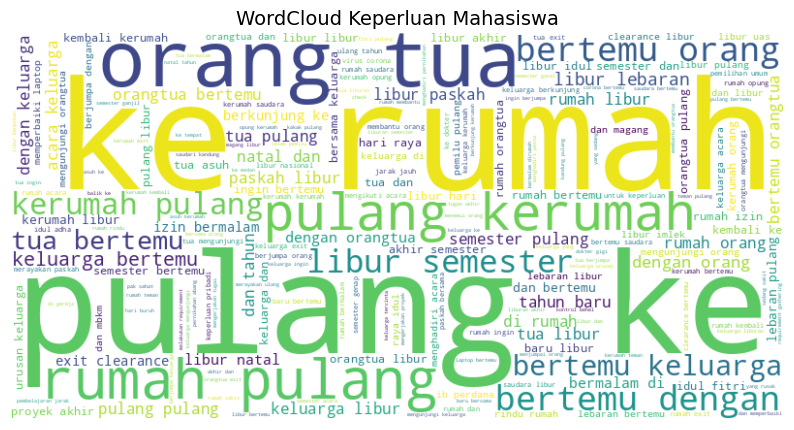

10 Kata Paling Umum dalam Keperluan:
pulang: 25158
rumah: 19215
ke: 18475
bertemu: 15071
libur: 14886
orang: 10994
tua: 10598
keluarga: 10439
kerumah: 9241
dan: 7372
dengan: 5415
semester: 4958
orangtua: 4349
di: 3142
lebaran: 2484
paskah: 2433
acara: 2111
tahun: 1919
bermalam: 1719
natal: 1713


In [3]:
from collections import Counter
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Hitung distribusi kata
all_keperluan = " ".join(data["keperluan"])
word_counts = Counter(all_keperluan.split())

# Tampilkan WordCloud
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(all_keperluan)
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("WordCloud Keperluan Mahasiswa", fontsize=14)
plt.show()

# Tampilkan kata paling umum
common_words = word_counts.most_common(20)
print("10 Kata Paling Umum dalam Keperluan:")
for word, count in common_words:
    print(f"{word}: {count}")


In [4]:
import re

# Klasifikasi keperluan
def classify_keperluan(text):
    if re.search(r"(laptop|printer|buku|barang)", text):
        return "Membeli Barang"
    elif re.search(r"(orangtua|orang tua|keluarga|saudara|pulang|rumah|bertemu|libur|pemilu|ib|pesta|pernikahan|natal|lebaran|paskah|acara|izin bermalam)", text):
        return "Bertemu Keluarga"
    elif re.search(r"(proyek|PKM|tugas|makalah|requirement|observasi|pa 1|pa 2| pa 3|tugas akhir|akhir)", text):
        return "Tugas Kuliah"
    elif re.search(r"(kontrol|gigi|behel|cabut|sakit|berobat)", text):
        return "Pergi ke Klinik"
    elif re.search(r"(atm|rekening|tabungan|kartu)", text):
        return "Mengurus Kartu Bank"
    elif re.search(r"(exit|clearance|wisuda)", text):
        return "Tamat Kuliah"
    else:
        return "Lainnya"

data["kategori"] = data["keperluan"].apply(classify_keperluan)


print(data["kategori"].value_counts())

data.to_csv("categorized_keperluan.csv", index=False)


kategori
Bertemu Keluarga       70672
Lainnya                 5440
Tamat Kuliah            1225
Pergi ke Klinik         1006
Membeli Barang           936
Tugas Kuliah             930
Mengurus Kartu Bank      157
Name: count, dtype: int64


In [5]:
opp_data = pd.read_csv("categorized_keperluan.csv")
opp_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80366 entries, 0 to 80365
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   keperluan  80366 non-null  object
 1   izin       80366 non-null  object
 2   kategori   80366 non-null  object
dtypes: object(3)
memory usage: 1.8+ MB


In [6]:
from sklearn.preprocessing import LabelEncoder

# Encode kategori menjadi nilai numerik
label_encoder = LabelEncoder()
opp_data["kategori_encoded"] = label_encoder.fit_transform(opp_data["kategori"])

print(opp_data[["kategori", "kategori_encoded"]].head())


           kategori  kategori_encoded
0  Bertemu Keluarga                 0
1  Bertemu Keluarga                 0
2  Bertemu Keluarga                 0
3  Bertemu Keluarga                 0
4  Bertemu Keluarga                 0


In [7]:
from sklearn.model_selection import train_test_split

# Fitur dan target
X = opp_data[["kategori_encoded"]]  # Menggunakan kategori encoded
y = opp_data["kategori_encoded"]

# Split data ke dalam train-test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print(f"Ukuran Train: {X_train.shape}, Ukuran Test: {X_test.shape}")

Ukuran Train: (56256, 1), Ukuran Test: (24110, 1)


In [8]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# Inisialisasi model
rf_model = RandomForestClassifier(random_state=42)

# Latih model
rf_model.fit(X_train, y_train)

# Prediksi pada test set
rf_predictions = rf_model.predict(X_test)

# Evaluasi performa
print("Random Forest Classifier Report:")
print(classification_report(y_test, rf_predictions))
print(f"Accuracy: {accuracy_score(y_test, rf_predictions):.2f}")


Random Forest Classifier Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     21244
           1       1.00      1.00      1.00      1599
           2       1.00      1.00      1.00       254
           3       1.00      1.00      1.00        55
           4       1.00      1.00      1.00       308
           5       1.00      1.00      1.00       359
           6       1.00      1.00      1.00       291

    accuracy                           1.00     24110
   macro avg       1.00      1.00      1.00     24110
weighted avg       1.00      1.00      1.00     24110

Accuracy: 1.00


In [9]:
from sklearn.linear_model import LogisticRegression

# Inisialisasi model
lr_model = LogisticRegression(random_state=42, max_iter=1000)

# Latih model
lr_model.fit(X_train, y_train)

# Prediksi pada test set
lr_predictions = lr_model.predict(X_test)

# Evaluasi performa
print("Logistic Regression Report:")
print(classification_report(y_test, lr_predictions))
print(f"Accuracy: {accuracy_score(y_test, lr_predictions):.2f}")


Logistic Regression Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     21244
           1       1.00      1.00      1.00      1599
           2       1.00      1.00      1.00       254
           3       1.00      1.00      1.00        55
           4       1.00      1.00      1.00       308
           5       1.00      1.00      1.00       359
           6       1.00      1.00      1.00       291

    accuracy                           1.00     24110
   macro avg       1.00      1.00      1.00     24110
weighted avg       1.00      1.00      1.00     24110

Accuracy: 1.00


In [10]:
from sklearn.model_selection import GridSearchCV

# Parameter untuk tuning
rf_params = {
    "n_estimators": [50, 100, 200],
    "max_depth": [None, 10, 20],
    "min_samples_split": [2, 5, 10],
}

# GridSearch
rf_grid = GridSearchCV(rf_model, rf_params, cv=3, scoring="accuracy")
rf_grid.fit(X_train, y_train)

print("Best Random Forest Params:", rf_grid.best_params_)
print(f"Best Accuracy: {rf_grid.best_score_:.2f}")


Best Random Forest Params: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 50}
Best Accuracy: 1.00


In [11]:
# Parameter untuk tuning
lr_params = {
    "C": [0.1, 1, 10],
    "solver": ["lbfgs", "liblinear"],
}

# GridSearch
lr_grid = GridSearchCV(lr_model, lr_params, cv=3, scoring="accuracy")
lr_grid.fit(X_train, y_train)

print("Best Logistic Regression Params:", lr_grid.best_params_)
print(f"Best Accuracy: {lr_grid.best_score_:.2f}")


Best Logistic Regression Params: {'C': 10, 'solver': 'lbfgs'}
Best Accuracy: 1.00


In [12]:
from sklearn.pipeline import Pipeline

# Pipeline Random Forest
rf_pipeline = Pipeline([
    ("rf", RandomForestClassifier(**rf_grid.best_params_, random_state=42))
])

# Pipeline Logistic Regression
lr_pipeline = Pipeline([
    ("lr", LogisticRegression(**lr_grid.best_params_, random_state=42, max_iter=1000))
])

# Latih ulang pipeline
rf_pipeline.fit(X_train, y_train)
lr_pipeline.fit(X_train, y_train)


Pipeline(steps=[('lr',
                 LogisticRegression(C=10, max_iter=1000, random_state=42))])

In [13]:
# Evaluasi Random Forest
rf_final_predictions = rf_pipeline.predict(X_test)
rf_final_accuracy = accuracy_score(y_test, rf_final_predictions)
print(f"Final Random Forest Accuracy: {rf_final_accuracy:.2f}")

# Evaluasi Logistic Regression
lr_final_predictions = lr_pipeline.predict(X_test)
lr_final_accuracy = accuracy_score(y_test, lr_final_predictions)
print(f"Final Logistic Regression Accuracy: {lr_final_accuracy:.2f}")


Final Random Forest Accuracy: 1.00
Final Logistic Regression Accuracy: 1.00


In [14]:
# Prediksi kategori untuk teks baru
new_texts = [
    "Pulang kerumah keluarga besar untuk Lebaran",
    "Membeli laptop baru untuk tugas kuliah",
    "Pergi ke rumah sakit untuk kontrol kesehatan"
]

# Fungsi klasifikasi menggunakan aturan sebelumnya
def classify_new_texts(texts):
    predicted_categories = []
    for text in texts:
        if re.search(r"(laptop|printer|buku|barang)", text):
            predicted_categories.append("Membeli Barang")
        elif re.search(r"(orangtua|orang tua|keluarga|saudara|pulang|rumah|bertemu|libur|pemilu|ib|pesta|pernikahan|natal|lebaran|paskah|acara|izin bermalam)", text):
            predicted_categories.append("Bertemu Keluarga")
        elif re.search(r"(proyek|PKM|tugas|makalah|requirement|observasi|pa 1|pa 2| pa 3|tugas akhir|akhir)", text):
            predicted_categories.append("Tugas Kuliah")
        elif re.search(r"(kontrol|gigi|behel|cabut|sakit|berobat)", text):
            predicted_categories.append("Pergi ke Klinik")
        elif re.search(r"(atm|rekening|tabungan|kartu)", text):
            predicted_categories.append("Mengurus Kartu Bank")
        elif re.search(r"(exit|clearance|wisuda)", text):
            predicted_categories.append("Tamat Kuliah")
        else:
            predicted_categories.append("Lainnya")
    return predicted_categories

# Klasifikasi menggunakan aturan
classified_texts = classify_new_texts(new_texts)
print("Classified Texts:", classified_texts)

# Convert kategori ke encoding numerik untuk prediksi model
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
opp_data["kategori_encoded"] = label_encoder.fit_transform(opp_data["kategori"])  # Pastikan ini telah dilakukan sebelumnya
new_text_encoded = label_encoder.transform(classified_texts)

# Prediksi menggunakan Random Forest
rf_predictions = rf_pipeline.predict(new_text_encoded.reshape(-1, 1))
rf_predictions_decoded = label_encoder.inverse_transform(rf_predictions)
print("Random Forest Predictions:", rf_predictions_decoded)

# Prediksi menggunakan Logistic Regression
lr_predictions = lr_pipeline.predict(new_text_encoded.reshape(-1, 1))
lr_predictions_decoded = label_encoder.inverse_transform(lr_predictions)
print("Logistic Regression Predictions:", lr_predictions_decoded)

# Map predictions to opportunities
opportunities = {
    "Membeli Barang": "Promosi produk elektronik dan alat tulis",
    "Bertemu Keluarga": "Penawaran tiket liburan atau transportasi",
    "Tugas Kuliah": "Layanan printing dan material akademik",
    "Pergi ke Klinik": "Paket layanan kesehatan",
    "Mengurus Kartu Bank": "Layanan pengelolaan keuangan mahasiswa",
    "Tamat Kuliah": "Dukungan karir dan sertifikasi tambahan",
    "Lainnya": "Layanan umum untuk kebutuhan mahasiswa"
}

print("Recommended Services:")
for category in rf_predictions_decoded:
    print(f"Category: {category} --> {opportunities.get(category, 'Tidak Ada Peluang')}")


Classified Texts: ['Bertemu Keluarga', 'Membeli Barang', 'Bertemu Keluarga']
Random Forest Predictions: ['Bertemu Keluarga' 'Membeli Barang' 'Bertemu Keluarga']
Logistic Regression Predictions: ['Bertemu Keluarga' 'Membeli Barang' 'Bertemu Keluarga']
Recommended Services:
Category: Bertemu Keluarga --> Penawaran tiket liburan atau transportasi
Category: Membeli Barang --> Promosi produk elektronik dan alat tulis
Category: Bertemu Keluarga --> Penawaran tiket liburan atau transportasi


/home/ownsys/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/home/ownsys/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
